### This notebook fits a BERTopic model to the data set and creates topic visualisations.
##### (using the data set with short tweets removed)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Run these two lines to have all plots appear on GitHub (do not run to use interactive plots within this notebook):
import plotly.io as pio

pio.renderers.default = "png"

In [3]:
# Set directory and file paths
READ_DIR = "../data/processed"

FILENAME = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_3wordtweetdrop_flightspellcorrect"

EMBEDDING_MPNET = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_3wordtweetdrop_flightspellcorrect_all-mpnet-base-v2.npy"

In [4]:
# Load embeddings
embeddings_mpnet = np.load(f"{READ_DIR}/{EMBEDDING_MPNET}")

In [5]:
# Load text data
df = pd.read_csv(f"{READ_DIR}/{FILENAME}.csv")

#### Set customisable parameters for BERTopic components:

In [6]:
# Parameters for UMAP
n_neighbors = 15
n_components = 5
min_dist = 0.1
metric_umap = "cosine"
random_state = 0

# UMAP model
reducer = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Parameters for HDBScan
min_cluster_size = 15
min_samples = 5
metric_hdbscan = "euclidean"
cluster_selection_method = "eom"

# HDBScan model
clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric_hdbscan,
    cluster_selection_method=cluster_selection_method,
    prediction_data=True,
)

# The lower and upper boundary of the range of n-values for different word n-grams
# or char n-grams to be extracted:
ngram_range = (1, 2)

#### Create functions to fit BERTopic model:

In [7]:
def get_bertmodel(ngram_range, umap_model, hdbscan_model):
    # Convert a collection of text documents to a matrix of token counts:
    vectorizer = CountVectorizer(
        stop_words=stopwords.words("english"),
        tokenizer=TweetTokenizer().tokenize,
        token_pattern=None,
        ngram_range=ngram_range,
    )

    # Fit BERTopic model with customisation:
    topic_model = BERTopic(
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
    )

    return topic_model


def get_topics_probs(model, docs, embeddings):
    topics, probs = model.fit_transform(docs, embeddings=embeddings)
    return topics, probs


def fit_bert(docs, embeddings, ngram_range, umap_model, hdbscan_model):
    bertmodel = get_bertmodel(
        ngram_range=ngram_range, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    topics, probs = get_topics_probs(model=bertmodel, docs=docs, embeddings=embeddings)

    return bertmodel, topics, probs

#### Fit BERTopic model using MPNET embeddings:

In [8]:
bertmodel_mpnet, topics_mpnet, probs_mpnet = fit_bert(
    docs=list(df.clean_text),
    embeddings=embeddings_mpnet,
    ngram_range=ngram_range,
    umap_model=reducer,
    hdbscan_model=clusterer,
)

##### Display the results table:
note: Topic -1 represents outliers 

In [9]:
df_bertopics_mpnet = bertmodel_mpnet.get_topic_info()
print("Number of topics: {}".format(len(df_bertopics_mpnet)))
df_bertopics_mpnet["Percentage"] = round(
    df_bertopics_mpnet["Count"] / df_bertopics_mpnet["Count"].sum() * 100, 2
)
df_bertopics_mpnet[:30]

Number of topics: 108


,Topic,Count,Name,Representation,Representative_Docs,Percentage
0,-1,6969,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, plane, time, ...",[Flight Booking Problems a flight using credit...,50.30
1,0,1041,0_bag_luggage_bags_baggage,"[bag, luggage, bags, baggage, lost, claim, lef...",[they lost my bag baggage handlers broke open ...,7.51
2,1,354,1_hold_call_phone_hours,"[hold, call, phone, hours, minutes, call back,...","[been on hold for over and hour now., been on ...",2.56
3,2,286,2_great_crew_attendant_thanks,"[great, crew, attendant, thanks, great flight,...","[great flight! And great view!, Another great ...",2.06
4,3,240,3_seat_seats_upgrade_class,"[seat, seats, upgrade, class, upgrades, seatin...",[it was booked through work but added upgrade ...,1.73
5,4,221,4_customers_customer_service_customer service,"[customers, customer, service, customer servic...","[WORST customer service ever!!!, customers che...",1.60
6,5,209,5_hold_cancelled_cancelled flight_rebook,"[hold, cancelled, cancelled flight, rebook, fl...",[been on hold for almost 2 hours trying to reb...,1.51
7,6,146,6_routes_start_flights_pdx,"[routes, start, flights, pdx, march, year, rou...",[Hi! Just wanted to see if you have any new ro...,1.05
8,7,126,7_food_catering_meal_eat,"[food, catering, meal, eat, coffee, peanuts, l...",[thanks for no fresh food on my cross country ...,0.91
9,8,125,8_twitter_tweet_social_media,"[twitter, tweet, social, media, social media, ...","[thx, social media person!, social media team ...",0.90


#### Choose a topic number and print data from the corresponding row:

In [10]:
topic_num = 0
for i, v in df_bertopics_mpnet.iloc[topic_num + 1].items():
    print(f"{i} : {v}")

Topic : 0
Count : 1041
Name : 0_bag_luggage_bags_baggage
Representation : ['bag', 'luggage', 'bags', 'baggage', 'lost', 'claim', 'left', 'checked', 'check', 'still']
Representative_Docs : ['they lost my bag baggage handlers broke open my bag and stole my camera', 'check your bag, bag handlers broke into my suitcase and stole my camera, bag was returned in a trash bag', 'Very frustrated, checked bag in Logan, was not given a luggage ticket, now luggage is lost & no ownership from']
Percentage : 7.51


#### Show topic words and c-TF-IDF scores:

In [11]:
bertmodel_mpnet.get_topic(0)

[('bag', 0.03290206602036792),
 ('luggage', 0.022486239186648983),
 ('bags', 0.022317845573958415),
 ('baggage', 0.01857980371236025),
 ('lost', 0.015154041733698227),
 ('claim', 0.009154511468075461),
 ('left', 0.007854508259923128),
 ('checked', 0.007428692585584272),
 ('check', 0.006676001130976437),
 ('still', 0.0066499259921279)]

##### For each topic, we can observe the most important words, sorted in decreasing order based on the c-TF-IDF score:

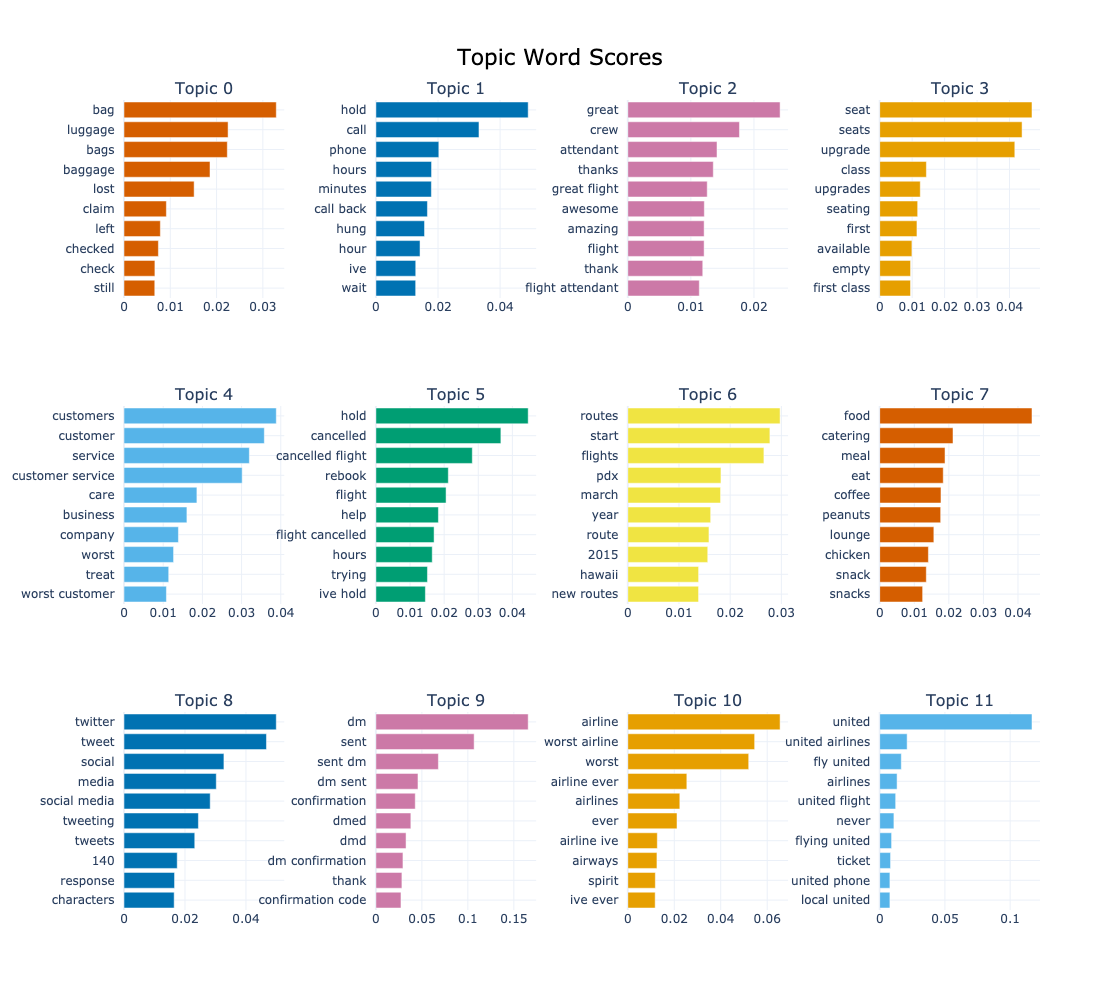

In [12]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

### Looking at sample of outliers:

In [13]:
df_topics = pd.DataFrame(
    {"Document": df["clean_text"], "Topic": bertmodel_mpnet.topics_}
)

outlier_tweets = df_topics["Document"][df_topics["Topic"] == -1]

[print(tweet) for tweet in outlier_tweets.sample(15, random_state=11)]

marks 15th birthday with painted in 'Blumanity' paint job
I don't know- no one would tell me where they were coming from - I would guess so as that's where we had all the changes to flights
flight 1025 JFK to TPA 8:05am on Saturday! One way ticket!
Is flight 5001 really going to leave Newark today? If not tell us now and I will rent a car. I do not want to end up stranded.
very frustrated. Bought early bird at 6:30am on day tickets were released and got mid-B ticket. Spend $50 for nothing
do new flights come out at midnight?
sale please soon?? I need a tan
Is there something going on with your alerts? Flight's been delayed several times for my parents and i'm not receiving any alerts.
missed it. Incoming on time, then Sat for 30, then no jetbridge driver.. .missed a 45min connection from an on time flight...
suggest you failures make a HUGE donation to Charlotte, NC as THEY provided GREAT customer service today, unlike you.
so what if I didn't have the funds to purchase another ticket?

### Where are the tweets about delays?

In [14]:
df_topics["Topic"][df_topics["Document"].str.contains("delay")].value_counts()[:10]

Topic
-1     536
 16     54
 26     52
 0      41
 15     40
 2      13
 19     11
 20     10
 50      8
 11      8
Name: count, dtype: int64

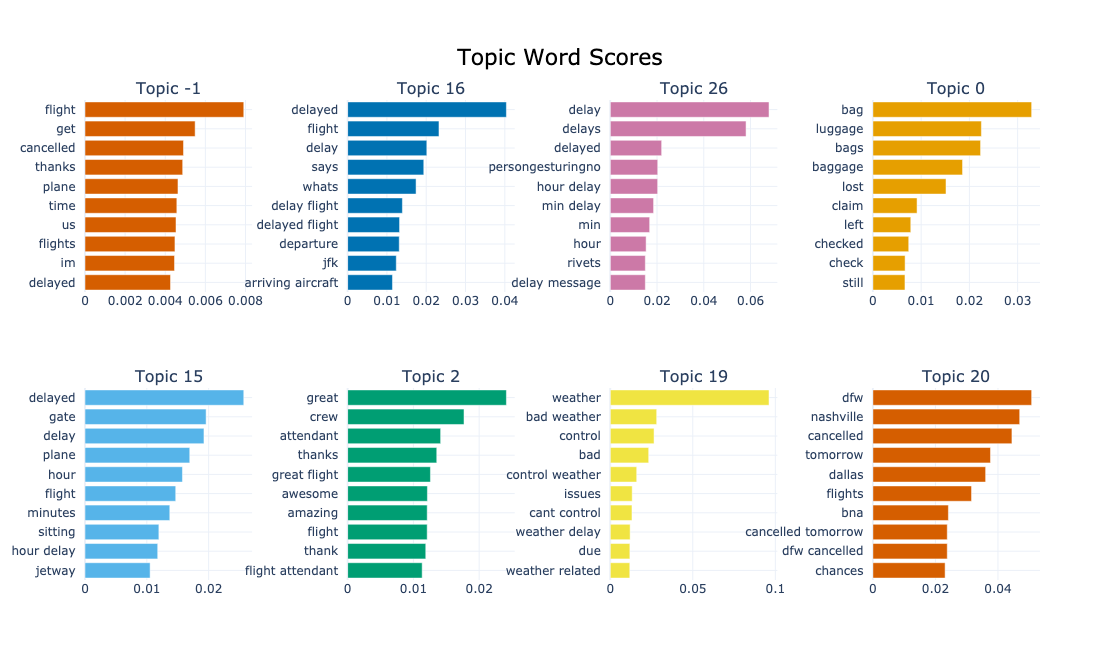

In [15]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, topics=[-1, 16, 26, 0, 15, 2, 19, 20], n_words=10
)
barchart.show()

In [16]:
# Look at samples of the topics that appear to be most specifically about delays:
for topic in [16, 26, 15]:
    [print(t) for t in bertmodel_mpnet.get_representative_docs(topic)]
    print()

Is today's JetBlue Flight 918 (NYC->BOS) delayed? My app says on time and the website says it's not...
how can your app show arriving aircraft is early but departing flight is delayed due to Late Flight arriving aircraft?
gate announcement states delay due to maintenance yet app says Late Flight arriving aircraft tell the truth!

the ones who suffer. I understand delays, I don't understand trying speed up a process that has been delays to this extent.
it's not about the delay. It's about the communication.
30 min delay for mechanics to replace rivets. 30 mins later, turns out mechanics had wrong size rivets. 35 more mins. Pathetic

Flight 4210 been sitting gate 27 for 10 min w door open since we arrived. Still no jet bridge. Can someone help?
40+ minutes waiting at the gate for the broken jetway. Different gate maybe?
Never can get a flight out on time. 4 hour delay earlier another hour delay on my connecting flight. Makes 10 straight delays



#### While there is distinction between some of the above, e.g. Topic 15 relates to gates, they are broadly about delays and so I will merge the topics:

In [17]:
topics_to_merge = [16, 26, 15]
bertmodel_mpnet.merge_topics(df["clean_text"], topics_to_merge)

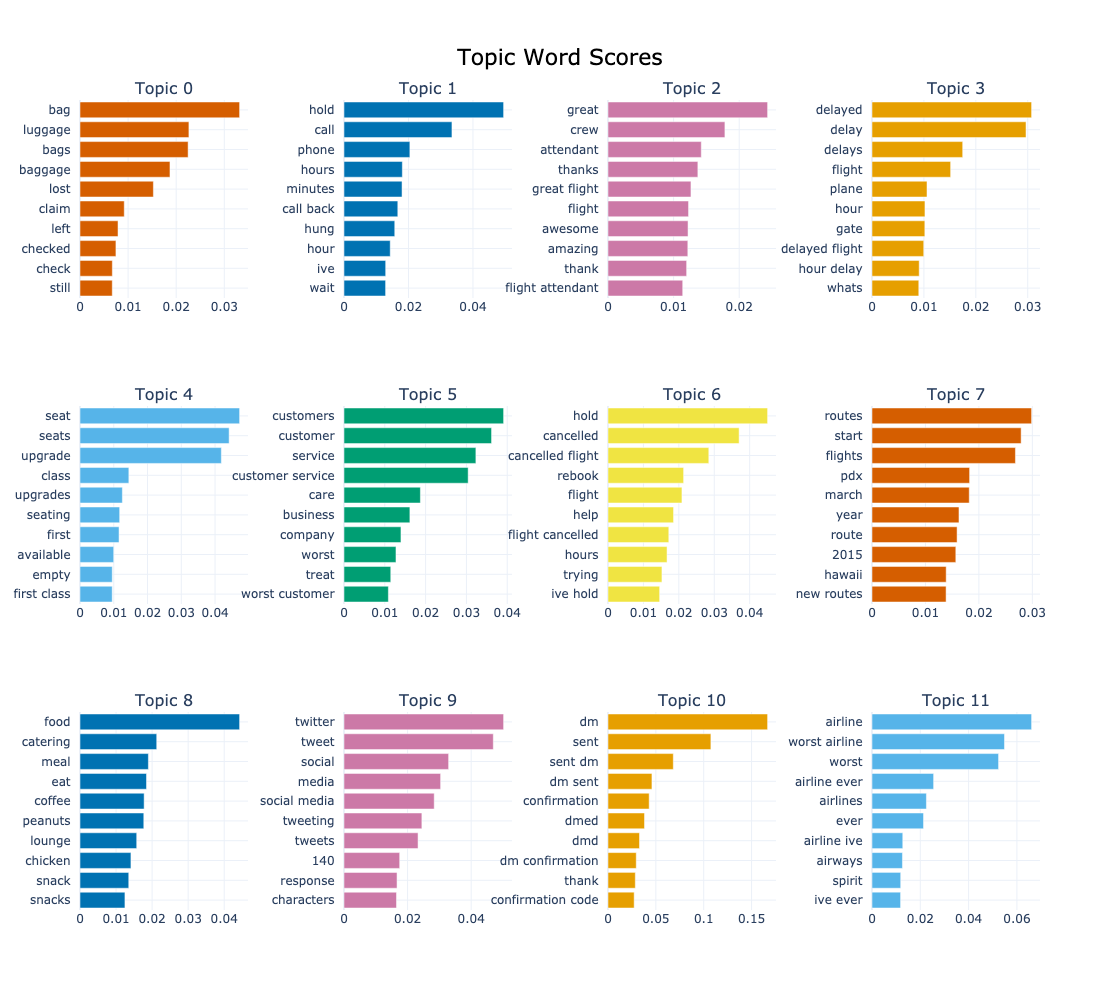

In [18]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

#### We can also see the distribution of topics per class, i.e. per Airline in this case:

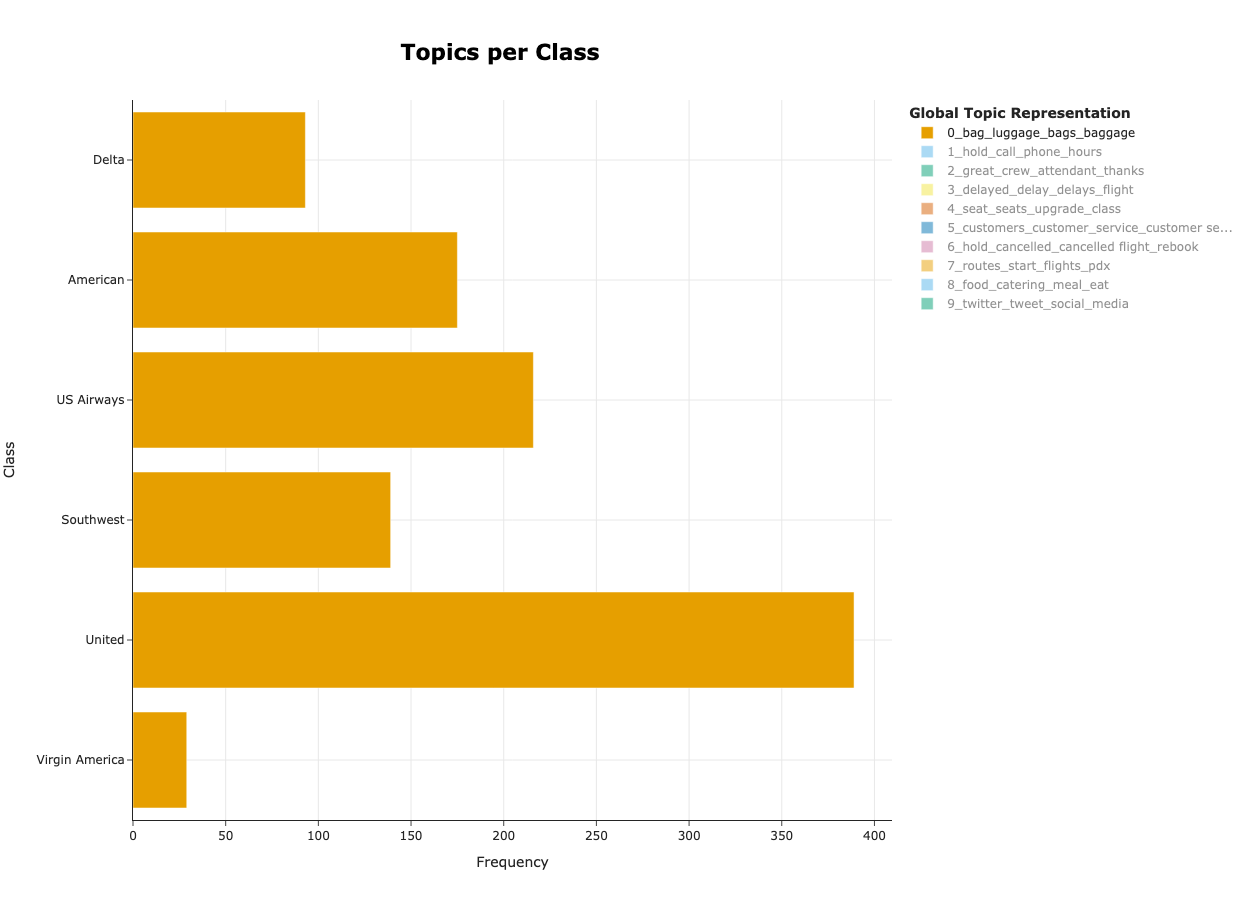

In [19]:
topics_per_class = bertmodel_mpnet.topics_per_class(
    df["clean_text"], classes=df["airline"]
)

bertmodel_mpnet.visualize_topics_per_class(
    topics_per_class, top_n_topics=10, normalize_frequency=False
)

## Look at document info table:

In [20]:
df_doc = bertmodel_mpnet.get_document_info(df["clean_text"])
df_doc["Airline"] = df["airline"]
df_doc.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,Airline
0,plus you've added commercials to the experienc...,5,5_customers_customer_service_customer service,"[customers, customer, service, customer servic...","[WORST customer service ever!!!, customer serv...",customers - customer - service - customer serv...,0.782115,False,Virgin America
1,I didn't today... Must mean I need to take ano...,30,30_yes_baggage_loading_would get,"[yes, baggage, loading, would get, ticket agen...","[why yes, yes it does!!!! Great trip down!! Th...",yes - baggage - loading - would get - ticket a...,1.000000,False,Virgin America
2,"it's really aggressive to blast obnoxious ""ent...",5,5_customers_customer_service_customer service,"[customers, customer, service, customer servic...","[WORST customer service ever!!!, customer serv...",customers - customer - service - customer serv...,0.812274,False,Virgin America
3,and it's a really big bad thing about it,-1,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, plane, time, ...",[Flight Booking Problems a flight using credit...,flight - get - cancelled - thanks - plane - ti...,0.000000,False,Virgin America
4,seriously would pay $30 a flight for seats tha...,-1,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, plane, time, ...",[Flight Booking Problems a flight using credit...,flight - get - cancelled - thanks - plane - ti...,0.000000,False,Virgin America


#### It would be useful to plot topic counts normalised by total tweets per airline, so we can see the prevalence of particular themes,<br> e.g. complaints as a fraction of total tweets. <br>
#### The dataset was scraped in a single month (February 2015), but how the data were scraped is not described in the source. Therefore, it is unclear how much of the total content on Twitter related to these operators is present. <br>
#### For the purpose of this investigation I will treat it as complete, but for real-world applications you would want to scrape all data related to a given set of operators over a long (possibly continuous) time period.

In [21]:
# Create a dictionary to map airline to total number of tweets associated
docs_per_airline = df["airline"].value_counts().to_dict()
docs_per_airline

{'United': 3658,
 'US Airways': 2831,
 'American': 2505,
 'Southwest': 2296,
 'Delta': 2089,
 'Virgin America': 475}

In [22]:
def plot_normalised_topics(
    data: pd.DataFrame,
    topics2plot: list[str],
    groupby_cols: list[str] = ["Topic", "Airline", "Name"],
    count_apply_col: str = "Airline",
    label_col: str = "Name",
    norm_dict: dict = docs_per_airline,
):
    """Function to plot normalised topic counts by a certain feature, e.g. count_apply_col = Airline"""
    df2plot = (
        data.groupby(groupby_cols)[count_apply_col].count().reset_index(name="Count")
    )
    df2plot_ = df2plot[df2plot["Topic"].isin(topics2plot)]
    df2plot_["Percentage"] = 100 * df2plot_.apply(
        lambda x: x["Count"] / norm_dict[x[count_apply_col]], axis=1
    )
    sns.barplot(df2plot_, x=count_apply_col, y="Percentage", hue=label_col).set_title(
        "Normalised topics"
    )
    plt.gcf().set_size_inches(12, 8)

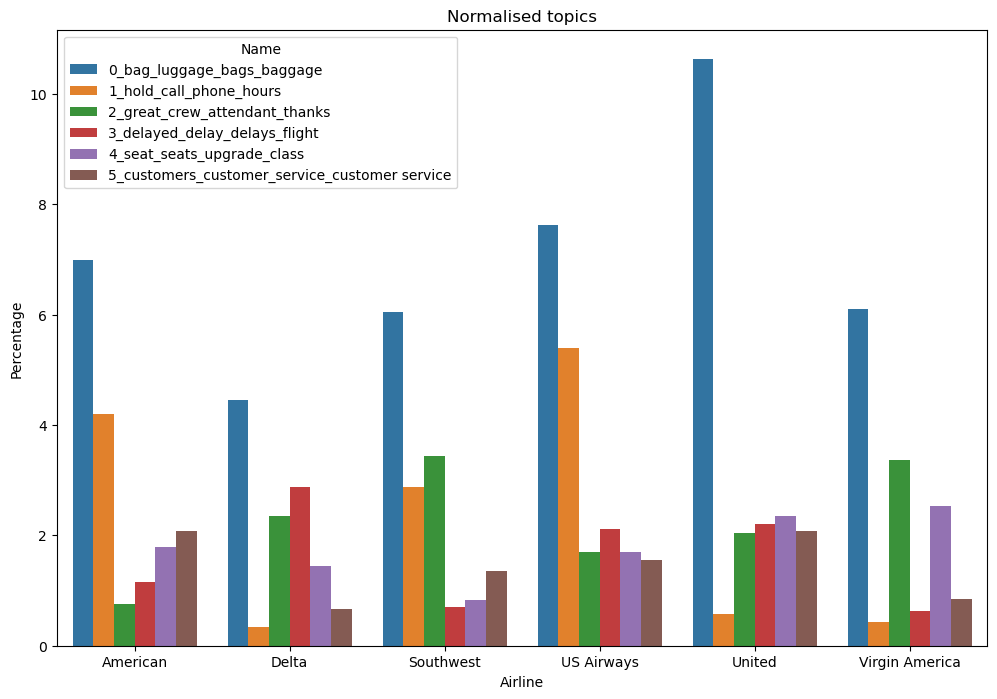

In [23]:
plot_normalised_topics(
    data=df_doc,
    topics2plot=[0, 1, 2, 3, 4, 5],
    groupby_cols=["Topic", "Airline", "Name"],
    count_apply_col="Airline",
    label_col="Name",
    norm_dict=docs_per_airline,
)

From the above, it appears that:
- United have the biggest issues related to baggage, although it's prevalent for all airlines
- American, Southwest and US Airways have siginificant issues related to being on hold on the phone
- Delta are most affected by delays
- Virgin America have a significant level of comment related to seat upgrades

In [24]:
# Print samples of the topics from above:
for topic in [0, 1, 2, 3, 4, 5]:
    [
        print(f"Topic {topic}: {t}")
        for t in bertmodel_mpnet.get_representative_docs(topic)
    ]
    print()

Topic 0: they lost my bag baggage handlers broke open my bag and stole my camera
Topic 0: check your bag, bag handlers broke into my suitcase and stole my camera, bag was returned in a trash bag
Topic 0: Very frustrated, checked bag in Logan, was not given a luggage ticket, now luggage is lost & no ownership from

Topic 1: been on hold for over and hour now.
Topic 1: been on hold for 1.5 hrs. What's up?
Topic 1: I've been on hold for 2 hours! When will you answer??

Topic 2: great flight! And great view!
Topic 2: Another great flight & crew, Las Vegas-Chicago. Thanks!
Topic 2: Great flight, as always! Thank you to the great crew on flight 475!

Topic 3: you know it's bad when you're praying your connecting flight is delayed because of an hour delay on the first flight
Topic 3: delayed due to We've heard it all!
Topic 3: it's not about the delay. It's about the communication.

Topic 4: I paid seat upgrade b4 the severe weather. Got booked on another flight but did not get upgrade. Was c

#### Create a 2D representation of the topics:

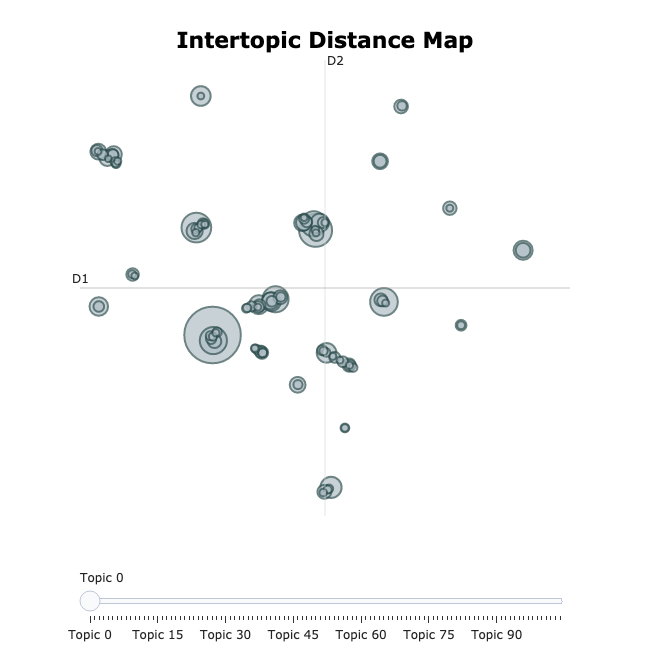

In [25]:
distance_map = bertmodel_mpnet.visualize_topics()
distance_map.show()

#### Visualise topic similarity with a heatmap:

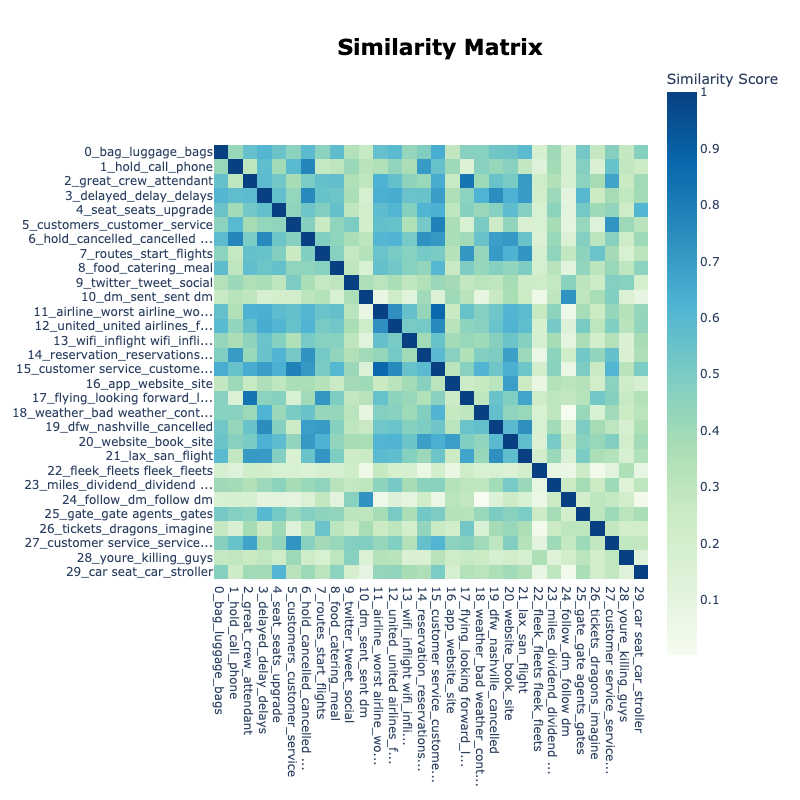

In [26]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(top_n_topics=30)
similarity_matrix.show()

#### We can also specify a number of clusters before creating the similarity matrix. Similar themes are then grouped together:

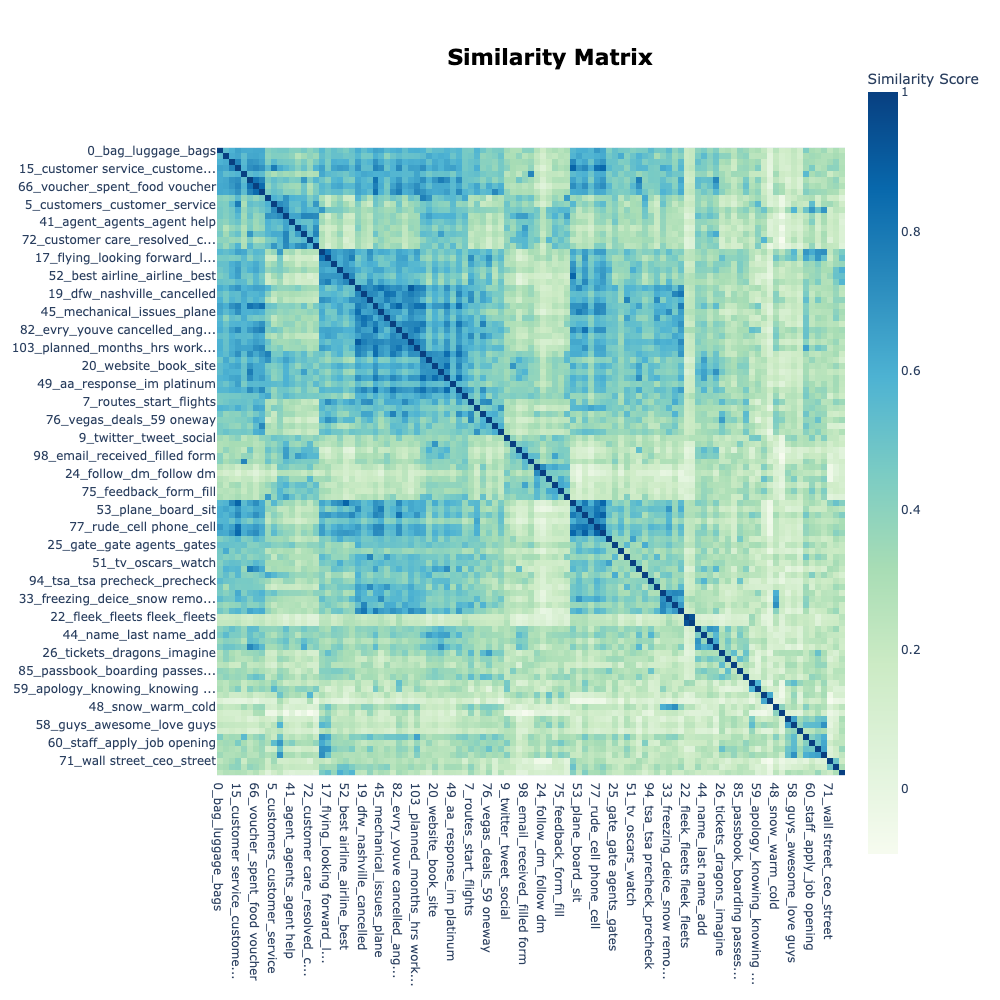

In [27]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(
    height=1000, width=1000, n_clusters=20
)
similarity_matrix.show()

#### Now visualise the documents within topics:

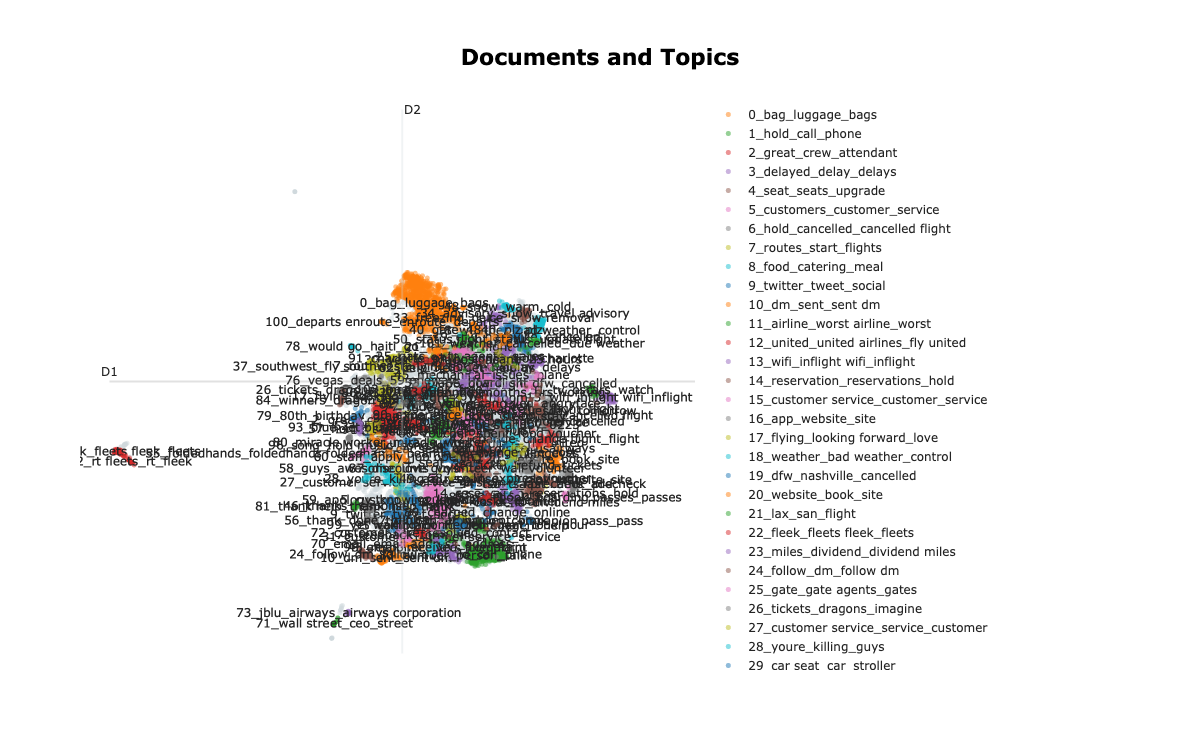

In [28]:
# Run the visualization with the original embeddings
# And viewing the original tweet text
bertmodel_mpnet.visualize_documents(docs=list(df.text), embeddings=embeddings_mpnet)

umap_vis = UMAP(
    n_neighbors=n_neighbors,
    n_components=2,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = umap_vis.fit_transform(embeddings_mpnet)
bertmodel_mpnet.visualize_documents(
    docs=list(df.text), reduced_embeddings=reduced_embeddings
)

### Visualise with wordclouds

In [29]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " " + str(topic))
    plt.show()

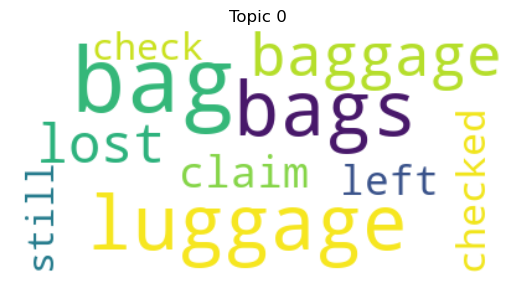

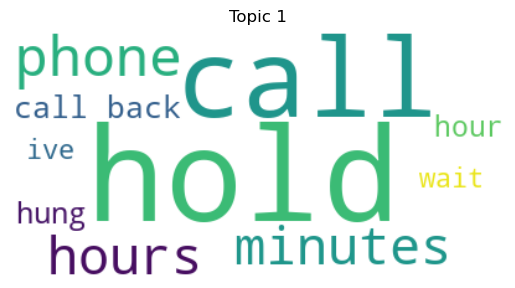

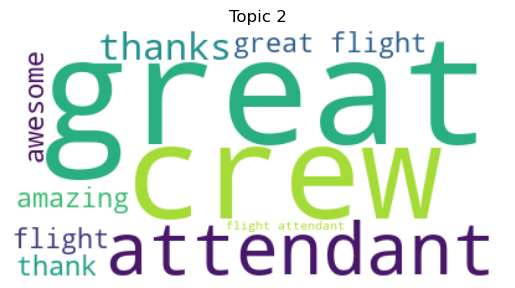

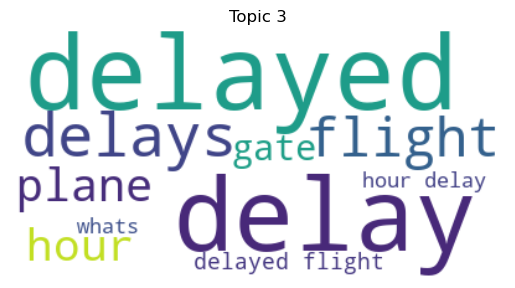

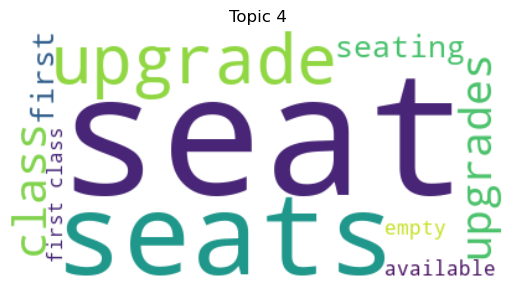

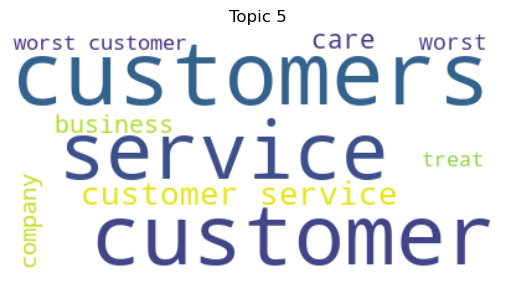

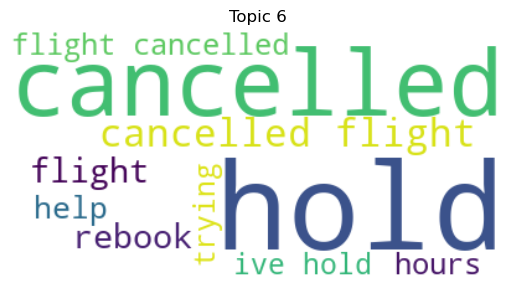

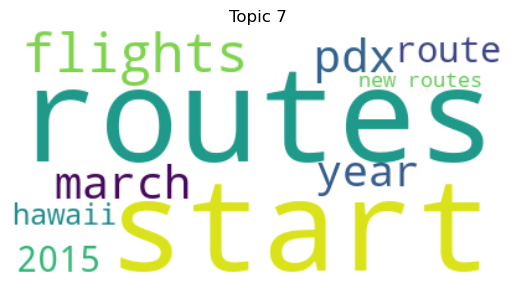

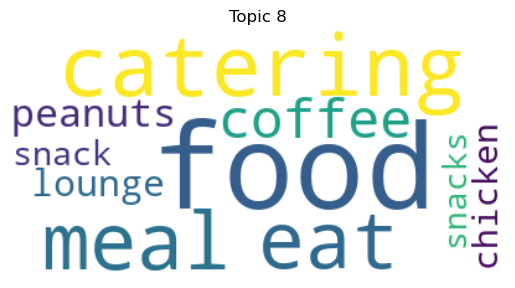

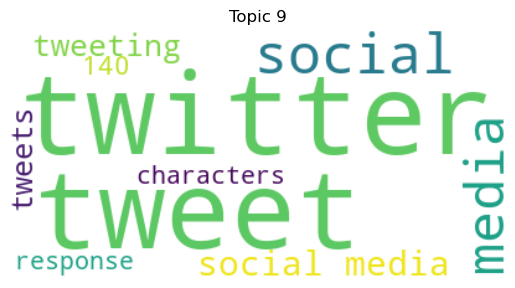

In [30]:
# Display the top 10 topics
for i in range(0, 10):
    create_wordcloud(bertmodel_mpnet, topic=i)

#### Save model:

In [35]:
# bertmodel_mpnet.save('../models/bertmodel_mpnet_3wordtweetdrop_delay_merge_flightspellcorrect', save_embedding_model=True)

#### To load:

In [6]:
# bertmodel_mpnet = BERTopic.load("../models/bertmodel_mpnet_3wordtweetdrop")
bertmodel_mpnet = BERTopic.load(
    "../models/bertmodel_mpnet_3wordtweetdrop_delay_merge_flightspellcorrect"
)

#### Another plot that is useful for seeing the distribution of topics and their frequencies is the Pareto Chart.
#### It could inform decisions about reducing topic numbers.

In [7]:
df_bertopics_mpnet = bertmodel_mpnet.get_topic_info()
print("Number of topics: {}".format(len(df_bertopics_mpnet)))

Number of topics: 106


In [8]:
# Dropping the outlier topic before calculating cumulative percentages:
df_no_outliers = df_bertopics_mpnet.drop(0)
df_no_outliers["cumperc"] = (
    df_no_outliers["Count"].cumsum() / df_no_outliers["Count"].sum() * 100
)
df_no_outliers.head()

,Topic,Count,Name,Representation,Representative_Docs,cumperc
1,0,1041,0_bag_luggage_bags_baggage,"[bag, luggage, bags, baggage, lost, claim, lef...",[they lost my bag baggage handlers broke open ...,15.119826
2,1,354,1_hold_call_phone_hours,"[hold, call, phone, hours, minutes, call back,...","[been on hold for over and hour now., been on ...",20.261438
3,2,286,2_great_crew_attendant_thanks,"[great, crew, attendant, thanks, great flight,...","[great flight! And great view!, Another great ...",24.415396
4,3,249,3_delayed_delay_delays_flight,"[delayed, delay, delays, flight, plane, hour, ...",[you know it's bad when you're praying your co...,28.031954
5,4,240,4_seat_seats_upgrade_class,"[seat, seats, upgrade, class, upgrades, seatin...",[I paid seat upgrade b4 the severe weather. Go...,31.517792


#### How many topics does it take to contain a given percentage of the documents which have topics assigned? 

In [11]:
# Set a threshold percentage to plot
threshold = 90

In [24]:
n = df_no_outliers["Topic"][df_no_outliers["cumperc"] < threshold].iloc[-1]

print(
    f"The first {n} topics contain ~{threshold}% of the documents which have topics assigned."
)

The first 67 topics contain ~90% of the documents which have topics assigned.


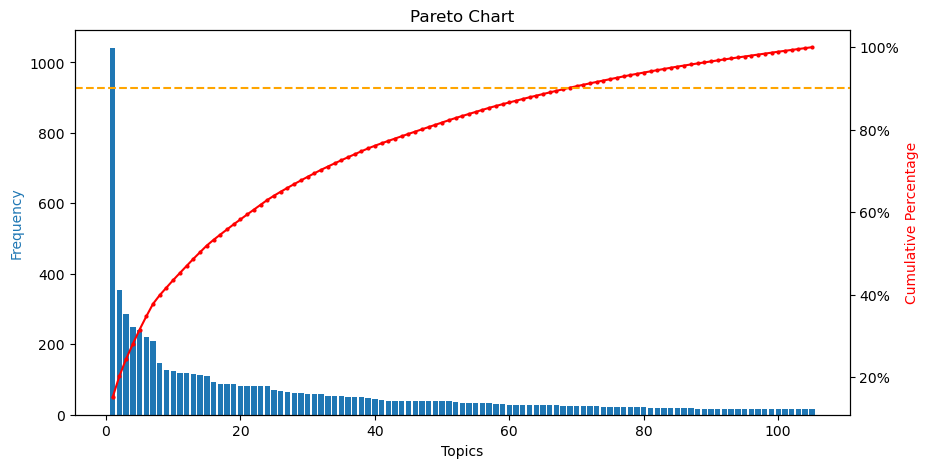

In [12]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(figsize=(10, 5))

# Plot frequency bar chart
ax.bar(df_no_outliers.index, df_no_outliers["Count"])
ax.set_title("Pareto Chart")
ax.set_xlabel("Topics")
ax.set_ylabel("Frequency", color="C0")

# Overlay the cumulative percentage
ax2 = ax.twinx()
ax2.plot(df_no_outliers.index, df_no_outliers["cumperc"], color="red", marker="o", ms=2)
ax2.axhline(threshold, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage", color="red")